# Part 2 : Stereo Correspondes 

In [26]:
#Installing libraries  
import cv2 
import os 
import numpy as np 
import matplotlib.pyplot as plt 

In [29]:
# Reading few images for testing . 

i1=cv2.imread('//home//niharika//CV_A2//ComputerAssignment2//stereo_images//1.jpg')
i2=cv2.imread('//home//niharika//CV_A2//ComputerAssignment2//stereo_images//2.jpg')
i3=cv2.imread('//home//niharika//CV_A2//ComputerAssignment2//stereo_images//3.jpeg')

i1 = i1.astype('uint8')
i2 = i2.astype('uint8')
i3 = i3.astype('uint8')


## Window based Intensity  Matching 

In [30]:
# Define Correlation as dot product(normalized) 
def corr(v1,v2):
    return v1.T.dot(v2)/(np.sqrt(v1.T.dot(v1))*np.sqrt(v2.T.dot(v2)))

In [12]:
def correlation_matching(img1,img2,window_size=128,stride=128,thresh = 0.01):
    h1,w1,c = img1.shape
    h2,w2,c = img2.shape
    
#     Pass through all the patches in img1 and find patch in img2 with least 
    best_matches = []
    for y1 in range(0,h1-window_size,stride):
        for x1 in range(0,w1-window_size,stride):
            least_dis = 1.0
            least_coord = []
            for y2 in range(0,h2-window_size,stride):
                for x2 in range(0,w2-window_size,stride):
                    v1 = img1[y1:y1+window_size, x1:x1+window_size,:].flatten()
                    v2 = img2[y2:y2+window_size, x2:x2+window_size,:].flatten()
                    dis = corr(v1,v2)
                    if least_dis > dis:
                        least_dis = dis
                        least_coord = [x1,y1,x2,y2,dis]
            best_matches.append(least_coord)
    return best_matches

In [31]:
def draw_matches(img,matches,window_size=128):
    h,w,c = img.shape
#     print(len(matches))
    line_img = []
    for match in matches:
        while len(match) < 4:
            match.append(0)
#         print(len(match))
        pt1 = (match[1]+window_size//2,match[0]+window_size//2)
        pt2 = (match[3]+window_size//2+w//2,match[2]+ window_size//2)
        line_img = cv2.line(img,pt1,pt2,(0,0,225),3)
    
    return line_img

Text(0.5, 1.0, 'Intensity Matches')

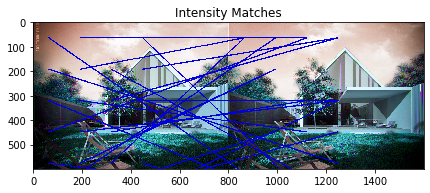

In [32]:
# Case 1
h,w,c = i1.shape
img1 = i1[:,0:w//2,:]
img2 = i1[:,w//2:w,:]
matches = correlation_matching(img1,img2)
dis_im = draw_matches(i1,matches)

fig=plt.figure(figsize=[7,7])
plt.imshow(dis_im)
plt.title('Intensity Matches')

Text(0.5, 1.0, 'Intensity Matches')

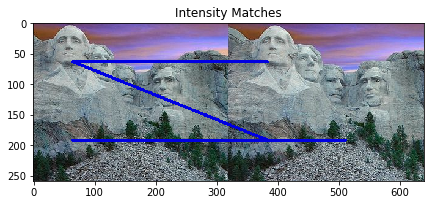

In [33]:
#Case 2 :
h,w,c = i2.shape
img1 = i2[:,0:w//2,:]
img2 = i2[:,w//2:w,:]
matches = correlation_matching(img1,img2)
dis_im = draw_matches(i2,matches)

fig=plt.figure(figsize=[7,7])
plt.imshow(dis_im)
plt.title('Intensity Matches')

# Stereo Rectification 

In [52]:
# We borrow the functions before . 
def siftfeatures(img):
    sift=cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #half = cv2.resize(gray,(0,0), fx = 0.2, fy = 0.2)
    kp, des = sift.detectAndCompute(gray,None)
    return kp,des

def featurematchingknn(img1,img2,verbose=False):
    
    bf=cv2.BFMatcher(cv2.NORM_L2,False)
    
    kp1,des1=siftfeatures(img1)
    kp2,des2=siftfeatures(img2)
    
 
    rawmatches = bf.knnMatch(des1,des2,k=2)
    
    matches = []


    for a,b in rawmatches:
        if a.distance < 0.4 * b.distance:
            matches.append(a)
        
    
    dp = dict(matchColor = (0,255,0), singlePointColor = None, flags=2)
    
    if(verbose):
        img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **dp) 
        fig=plt.figure(figsize=[10,10])
        plt.imshow(img3)
        plt.title("Features Matched")
        plt.show()
        
    # Points Generation . 
    pts1=np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,2)
    pts2=np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,2)
    
    return(matches,kp1,kp2,pts1,pts2)
    
def computeRow(pointP,pointQ):
    row1=[-pointP[0],-pointP[1],-1,0,0,0,pointP[0]*pointQ[0],pointP[1]*pointQ[0],pointQ[0]]
    row2=[0,0,0,-pointP[0],-pointP[1],-1,pointP[0]*pointQ[1],pointP[1]*pointQ[1],pointQ[1]]
    
    return(np.vstack((row1,row2)))

def homographyMatrix(srcpts,despts):
    M=[]
    N=len(srcpts);
    for i in zip(srcpts,despts):
        A=computeRow(i[0],i[1])
        M.append(A)
    M=np.asarray(M)
    m,n,p=M.shape
    M=np.reshape(np.asarray(M),(m*n,p))
    
    # Computing the SVD part .
    U, D, V_T =np.linalg.svd(M)
    #Extrating the last column of V
    H=np.reshape(V_T[-1,:]/V_T[-1,-1],(3,3))
    
    # MSE Error . 
    # Calculating the Mean error now , as H is known to us . 
    # Take up all world co-ordinates ,mul by H , we know the corresponding image co-ordinates .
    
    mse=0;
    despt_append=[ [despts[i][0],despts[i][1],1] for i in range(0,len(despts)) ] 
    
    for i in range(0,1,len(despts)) : 
        xcPred=np.dot(H,np.reshape(np.asarray(despt_append[i]),(3,1)));
        xcPred=xcPred[0:2]/xcPred[-1]
        mse=mse+np.linalg.norm((np.reshape(np.asarray(despts[i]),(2,1))-xcPred))
        
    mse=mse/len(despts)
    return(H,mse)

def homographyRANSAC(scrpts,despts,verbose=False):
    #For Computation  of Homography any 4 pts are enough.
    scrpts=list(scrpts)
    despts=list(despts)
    N=len(scrpts)
    
    if(N<4):
        print('Homography cannot be computed , pls enter more points')
        return(0);
    
    mse_max=1000000;
    for subset in itertools.combinations(range(0,N),4):
        Si=[scrpts[i] for i in subset]
        Di=[despts[i] for i in subset]
        # Calling Homography Function . 
        Hi,erri=homographyMatrix(Si,Di)
        if(erri<mse_max):
            H,mse=homographyMatrix(Si,Di)
            msemax=mse
    return(H,mse)             


def warp_project(imageA, imageB, homography,verbose=True):    
    h1, w1 = imageA.shape[:2]
    h2, w2 = imageB.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    
    pts2_ = cv2.perspectiveTransform(pts2, homography)
    
    pts = np.concatenate((pts1, pts2_), axis=0)
    
    [xmin, ymin] = np.int8(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int8(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    result = cv2.warpPerspective(imageB, Ht.dot(homography), (xmax-xmin, ymax-ymin))
    cv2.imwrite("project.png", result)
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = imageA
    
    if(verbose):
        fig=plt.figure(figsize=[10,10])
        gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
        plt.imshow(gray)
        plt.title('Stiched Image')
    return(result)



In [65]:
def stereoRectification(im1,im2,match_thresh=0.8,verbose=False):
    
    #Generate SIFT parameters & store the matches .
    matches,kp1,kp2,pts1,pts2=featurematchingknn(img1,img2,verbose=False)
    #RANSAC inbuilt function .
    F,mask = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC)
    
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    img_size = img1.shape[0:2]
    
    p,H1,H2=cv2.stereoRectifyUncalibrated(pts1, pts2, F, img_size)
        
    H3=H1.dot(H2)
    
    img1_corrected = cv2.warpPerspective(img1, H1, img_size)
    img2_corrected = cv2.warpPerspective(img2, H3, img_size)
    
    
    imgadd=np.hstack((np.asarray(img2_corrected),np.asarray(img1_corrected)))

    return imgadd,img1_corrected, img2_corrected
    

Text(0.5, 1.0, 'Intensity Matches')

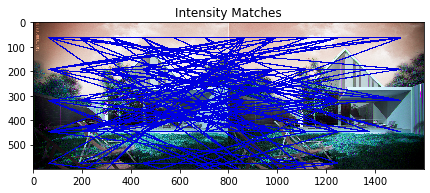

In [66]:
#Case 1 :

# Case 1
h,w,c = i1.shape
img1 = i1[:,0:w//2,:]
img2 = i1[:,w//2:w,:]

I,I1,I2=stereoRectification(img1,img2,match_thresh=0.8,verbose=True)

matches = correlation_matching(I1,I2)
dis_im = draw_matches(i1,matches)


fig=plt.figure(figsize=[7,7])
plt.imshow(dis_im)
plt.title('Intensity Matches')



Text(0.5, 1.0, 'Intensity Matches')

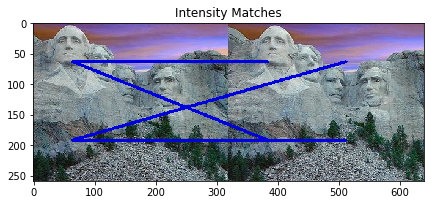

In [67]:
# Perform Itensity Matching on I1 & I2

# Case 2
h,w,c = i2.shape
img1 = i2[:,0:w//2,:]
img2 = i2[:,w//2:w,:]

I,I1,I2=stereoRectification(img1,img2,match_thresh=0.8,verbose=True)

matches = correlation_matching(I1,I2)
dis_im = draw_matches(i2,matches)


fig=plt.figure(figsize=[7,7])
plt.imshow(dis_im)
plt.title('Intensity Matches')


Text(0.5, 1.0, 'Intensity Matches')

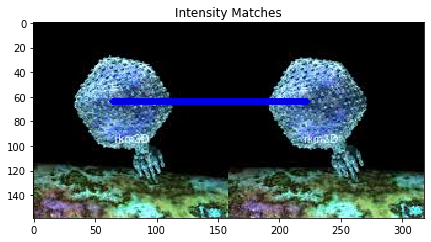

In [68]:

# Case 3
h,w,c = i3.shape
img1 = i3[:,0:w//2,:]
img2 = i3[:,w//2:w,:]

I,I1,I2=stereoRectification(img1,img2,match_thresh=0.8,verbose=True)

matches = correlation_matching(I1,I2)
dis_im = draw_matches(i3,matches)


fig=plt.figure(figsize=[7,7])
plt.imshow(dis_im)
plt.title('Intensity Matches')

# Part 3 : Dynamic Programming & Greedy ALgorithms 